In [73]:
using Revise
using RadiativeTransfer
using RadiativeTransfer.PhaseFunction
using RadiativeTransfer.RTM
using Distributions

In [74]:
"Generate aerosol optical properties"

# Wavelength (just one for now)
λ = 0.55       # Incident wavelength
depol = 0.0
# Truncation 
Ltrunc = 40             # Truncation  
truncation_type   = δBGE(Ltrunc, 2.0)

# polarization_type
polarization_type = Stokes_IQUV()

# Quadrature points for RTM
Nquad, qp_μ, wt_μ = rt_set_streams(RTM.RadauQuad(), Ltrunc, 60.0, [0.0, 15.0, 30., 45., 60.])

# Aerosol particle distribution and properties
μ            = [0.3,2.0]       # Log mean radius
σ            = [2.0,1.8]       # Log stddev of radius
r_max        = [30.0,30.0]     # Maximum radius
nquad_radius = [2500,2500]     # Number of quadrature points for integrating of size dist.
nᵣ           = [1.3, 1.66]     # Real part of refractive index
nᵢ           = [0.001,0.0003]  # Imag part of refractive index

#Aerosol vertical distribution profiles
p₀           = [50000., 20000.] # Pressure peak [Pa]
σp          = [5000., 2000.]   # Pressure peak width [Pa]

size_distribution = [LogNormal(log(μ[1]), log(σ[1])), LogNormal(log(μ[2]), log(σ[2]))]

# Create the aerosols (needs to be generalized through loops):
aero1 = make_univariate_aerosol(size_distribution[1], r_max[1], nquad_radius[1], nᵣ[1], nᵢ[1])
aero2 = make_univariate_aerosol(size_distribution[2], r_max[2], nquad_radius[2], nᵣ[2], nᵢ[2])

# Define some details, run aerosol optics
model_NAI2_aero1 = make_mie_model(NAI2(), aero1, λ, polarization_type, truncation_type)
aerosol_optics_NAI2_aero1 = compute_aerosol_optical_properties(model_NAI2_aero1);
# Truncate:
aerosol_optics_trunc_aero1 = PhaseFunction.truncate_phase(truncation_type, aerosol_optics_NAI2_aero1)

# Define some details, run aerosol optics
model_NAI2_aero2 = make_mie_model(NAI2(), aero2, λ, polarization_type, truncation_type)
aerosol_optics_NAI2_aero2 = compute_aerosol_optical_properties(model_NAI2_aero2);
# Truncate:
aerosol_optics_trunc_aero2 = PhaseFunction.truncate_phase(truncation_type, aerosol_optics_NAI2_aero2)

# Rayleigh Greek
GreekRayleigh = PhaseFunction.get_greek_rayleigh(depol)


┌ Info: Fraction of size distribution cut by max radius: 1.5279000287193867e-9 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:263
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:02
┌ Info: Fraction of size distribution cut by max radius: 0.00020406457610366857 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:263
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:02


GreekCoefs{Float64}([0.0, 0.0, 3.0], [1.0, 0.0, 0.5], [0.0, 0.0, 1.224744871391589], [0.0, 1.5, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [75]:
vza = [60., 45., 30., 15., 0., 15., 30., 45., 60.]
vaz = [180., 180., 180., 180., 0., 0., 0., 0., 0.]
sza = 60.
Nquad, qp_μ, wt_μ = rt_set_streams(RTM.RadauQuad(), Ltrunc, sza, vza)

(25, [0.0059588067162077984, 0.030866035938574038, 0.0735557248215351, 0.13057983800422812, 0.19731992344289342, 0.2683693828578303, 0.33797223083833255, 0.4004894605184494, 0.4508554938950734, 0.4849854839192568  …  0.6973199234428934, 0.7683693828578303, 0.8379722308383326, 0.9004894605184495, 0.9508554938950734, 0.9849854839192568, 1.0, 0.7071067811865476, 0.8660254037844386, 0.9659258262890683], [0.015231274453032781, 0.03425842053330057, 0.050540777135006106, 0.0627313444242821, 0.06984033327584575, 0.07129139098525183, 0.06696677154742099, 0.05721653096224421, 0.042829404801664944, 0.024961520476991964  …  0.06984033327584575, 0.07129139098525183, 0.06696677154742099, 0.05721653096224421, 0.042829404801664944, 0.024961520476991964, 0.004132231404958678, 0.0, 0.0, 0.0])

In [76]:
" Atmospheric Profiles, basics, needs to be refactore entirely"
file = "/Users/sanghavi/GDrive/code/github/atm_profiles/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4"   
timeIndex = 2 # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

# What latitude do we want? 
myLat = 34.1377;
myLon = -118.1253;

# Read profile (and generate dry/wet VCDs per layer)
profile_caltech = RTM.read_atmos_profile(file, myLat, myLon, timeIndex);

# Compute layer optical thickness for Rayleigh (surface pressure in hPa) 
τRayl =  RTM.getRayleighLayerOptProp(profile_caltech.psurf/100, λ, depol, profile_caltech.vcd_dry);
ϖRayl = ones(length(τRayl))

#Compute Naer aerosol optical thickness profiles
τAer_1 = RTM.getAerosolLayerOptProp(1.0, p₀[1], σp[1], profile_caltech.p_levels)
τAer_2 = RTM.getAerosolLayerOptProp(0.3, p₀[2], σp[2], profile_caltech.p_levels)

# Can be done with arbitrary length later:
τAer = [τAer_1 τAer_2]
@show sum(τAer_1), sum(τAer_2)
ϖAer = [aerosol_optics_NAI2_aero1.ω̃ aerosol_optics_NAI2_aero2.ω̃];
fᵗ   = [aerosol_optics_trunc_aero1.fᵗ aerosol_optics_trunc_aero2.fᵗ];


(sum(τAer_1), sum(τAer_2)) = (1.0, 0.30000000000000004)


In [54]:
m = 0
RaylZ⁺⁺, RaylZ⁻⁺     = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, GreekRayleigh, m);
aero1_Z⁺⁺, aero1_Z⁻⁺ = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, aerosol_optics_trunc_aero1.greek_coefs, m);
aero2_Z⁺⁺, aero2_Z⁻⁺ = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, aerosol_optics_trunc_aero2.greek_coefs, m);
aerosol_optics = [aerosol_optics_trunc_aero1 aerosol_optics_trunc_aero2]
Aer𝐙⁺⁺ = [aero1_Z⁺⁺, aero2_Z⁺⁺];
Aer𝐙⁻⁺ = [aero1_Z⁻⁺, aero2_Z⁻⁺];

iz = 10
τ, ϖ, Z⁺⁺, Z⁻⁺  = RTM.construct_atm_layer(τRayl[iz], τAer[iz,:], ϖRayl[iz], ϖAer, fᵗ, RaylZ⁺⁺, RaylZ⁻⁺, Aer𝐙⁺⁺, Aer𝐙⁻⁺)
@show τ, ϖ
@show τAer[iz,:], τRayl[iz]

(τ, ϖ) = (8.309208591510007e-6, 1.0)
(τAer[iz, :], τRayl[iz]) = ([1.0921404610080213e-25, 9.601082758390844e-26], 8.309208591510007e-6)


([1.0921404610080213e-25, 9.601082758390844e-26], 8.309208591510007e-6)

In [77]:
@show size(Z⁺⁺)
@show size(qp_μ)
RTM.rt_elemental(dτ, ϖ, Z⁺⁺, Z⁻⁺, 0, ndoubl, true, qp_μ, wt_μ)

size(Z⁺⁺) = (100, 100)
size(qp_μ) = (25,)


([0.0033697716871199184 -0.001123124282330628 … -0.0 -0.0; -0.001123124282330628 0.003369612147669808 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 0.0; -0.0 -0.0 … -0.0 -0.0], [0.6100443775901676 -0.001123124282330628 … 0.0 0.0; -0.001123124282330628 0.6100442180507175 … 0.0 0.0; … ; 0.0 0.0 … 0.9975735714521639 0.0; 0.0 0.0 … -0.0 0.9975735714521639], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 -0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [78]:
r⁻⁺, t⁺⁺, r⁺⁻, t⁻⁻ = RTM.rt_elemental(dτ, ϖ, Z⁺⁺, Z⁻⁺, 0, ndoubl, true, qp_μ, wt_μ)


([0.0033697716871199184 -0.001123124282330628 … -0.0 -0.0; -0.001123124282330628 0.003369612147669808 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 0.0; -0.0 -0.0 … -0.0 -0.0], [0.6100443775901676 -0.001123124282330628 … 0.0 0.0; -0.001123124282330628 0.6100442180507175 … 0.0 0.0; … ; 0.0 0.0 … 0.9975735714521639 0.0; 0.0 0.0 … -0.0 0.9975735714521639], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 -0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

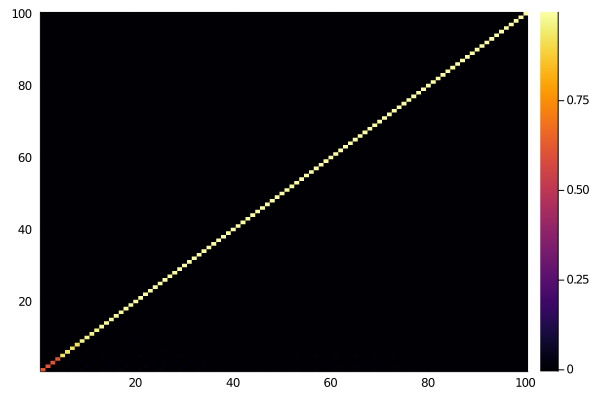

In [47]:
using Plots
#heatmap(r⁻⁺)
heatmap(t⁺⁺)


In [13]:
@show size(r⁻⁺,1)

size(r⁻⁺, 1) = 100


100

In [79]:
r⁻⁺, t⁺⁺, r⁺⁻, t⁻⁻ = RTM.rt_doubling(dτ, 0.3, ndoubl, r⁻⁺, t⁺⁺, r⁺⁻, t⁻⁻)


([-0.005484516016827933 0.0018551055942712792 … -0.0 -0.0; 0.0018551055942712797 -0.005465872638561366 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; 0.0 0.0 … 0.0 0.0], [4.184974733975686e-5 -1.2981516724804324e-5 … 0.0 0.0; -1.2981516724804324e-5 2.711711550548481e-5 … 0.0 0.0; … ; 0.0 0.0 … 0.7327429884076178 0.0; 0.0 0.0 … 0.0 0.7327429884076178], [-0.005484516016827933 0.0018551055942712792 … 0.0 0.0; 0.0018551055942712797 -0.005465872638561366 … 0.0 0.0; … ; 0.0 0.0 … -0.0 -0.0; -0.0 -0.0 … 0.0 0.0], [4.184974733975686e-5 -1.2981516724804324e-5 … -0.0 -0.0; -1.2981516724804324e-5 2.711711550548481e-5 … -0.0 -0.0; … ; -0.0 -0.0 … 0.7327429884076178 0.0; -0.0 -0.0 … 0.0 0.7327429884076178])

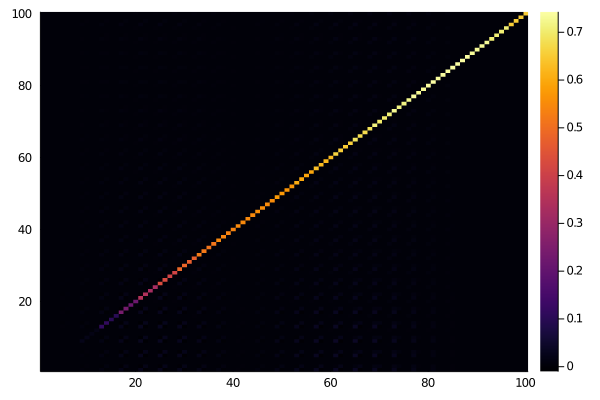

In [71]:
using Plots
#heatmap(r⁺⁻)
#heatmap(t⁺⁺)
heatmap(t⁻⁻)


In [101]:
R,T = RTM.run_RTM(polarization_type, sza, vza, vaz, τRayl,ϖRayl, τAer, ϖAer, fᵗ, qp_μ, wt_μ, Ltrunc, aerosol_optics, GreekRayleigh)

(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (1, 60.0, 0.5, 11, 0.5)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (2, 45.0, 0.7071067811865476, 23, 0.7071067811865476)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (3, 30.0, 0.8660254037844386, 24, 0.8660254037844386)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (4, 15.0, 0.9659258262890683, 25, 0.9659258262890683)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (5, 0.0, 1.0, 22, 1.0)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (6, 15.0, 0.9659258262890683, 25, 0.9659258262890683)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (7, 30.0, 0.8660254037844386, 24, 0.8660254037844386)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (8, 45.0, 0.7071067811865476, 23, 0.7071067811865476)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (9, 60.0, 0.5, 11, 0.5)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (1, 60.0, 0.5, 11, 0.5)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (2, 45.0, 0.7071067811865476, 23, 0.7071067811865476)
(i, vza[i], cosd(vza[i]), iμ, qp_μ[iμ]) = (3, 30.0, 0.86602540378

([-5.054151621442882 -0.005373223139662396 0.0 0.0; -1.2056067729951037 0.03132538793624871 0.0 0.0; … ; 3.018971001007645 -0.020847963988738567 0.0 0.0; 11.757282222894226 -0.03192947724345962 0.0 0.0], [-0.08254331162990404 -0.002649297635485579 0.0 0.0; -0.12013551476735405 -0.006266511851204623 0.0 0.0; … ; 0.7123983751636398 0.0016546961644765387 0.0 0.0; 0.2438451564188259 0.0012253267639133504 0.0 0.0])

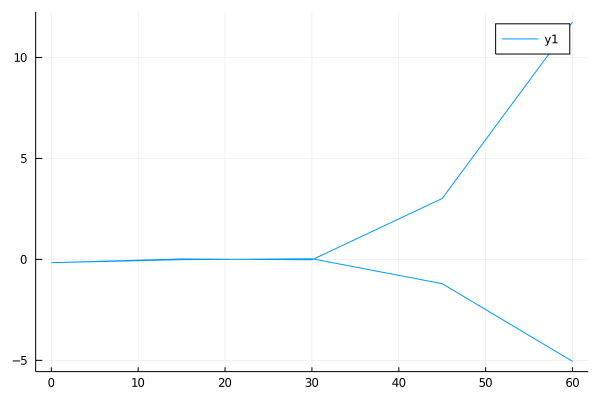

In [103]:
using Plots
plot(vza, R[:,1])

In [61]:
i = RTM.nearest_point(qp_μ, 0.5)

11

In [89]:
using LinearAlgebra
phi = 180
m=0
cos_m_phi = cosd(m*phi)
sin_m_phi = sind(m*phi)

Diagonal([cos_m_phi, cos_m_phi, sin_m_phi, sin_m_phi])

4×4 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅   0.0   ⋅ 
  ⋅    ⋅    ⋅   0.0